In [1]:
# Explcit feedback based music recommendation system 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse
from scipy.sparse import csr_matrix, find
from scipy.sparse.linalg import spsolve
from scipy.stats import * 
from scipy import spatial
from scipy.spatial.distance import pdist
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import model_selection
from sklearn import preprocessing
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics.pairwise import cosine_similarity
import random
import matplotlib.mlab as mlb
import seaborn as sns

## Data Preparation and Cleaning

Load activity dataframe with parameters and check df head

In [3]:
activity_data = pd.read_table('usersha1-artmbid-artname-plays.tsv', header = None, 
                names = ['users', 'musicbrainz-artist-id', 'artist-name', 'plays'],
                usecols = ['users', 'artist-name', 'plays'])
activity_data.head()

,users,artist-name,plays
0,00000c289a1829a808ac09c00daf10bc3c4e223b,betty blowtorch,2137
1,00000c289a1829a808ac09c00daf10bc3c4e223b,die Ärzte,1099
2,00000c289a1829a808ac09c00daf10bc3c4e223b,melissa etheridge,897
3,00000c289a1829a808ac09c00daf10bc3c4e223b,elvenking,717
4,00000c289a1829a808ac09c00daf10bc3c4e223b,juliette & the licks,706


Load profile dataframe with parameters  and check df head

In [4]:
profile_data = pd.read_table('usersha1-profile.tsv', header = None, names = ['users', 'gender', 'age', 'country'], 
                             usecols = ['users', 'gender', 'age', 'country'])
profile_data.head()

,users,gender,age,country
0,00000c289a1829a808ac09c00daf10bc3c4e223b,f,22.0,Germany
1,00001411dc427966b17297bf4d69e7e193135d89,f,NaN,Canada
2,00004d2ac9316e22dc007ab2243d6fcb239e707d,NaN,NaN,Germany
3,000063d3fe1cf2ba248b9e3c3f0334845a27a6bf,m,19.0,Mexico
4,00007a47085b9aab8af55f52ec8846ac479ac4fe,m,28.0,United States


Prepare EDA dataset

In [5]:
# Fill missing age values with mean average
profile_data['age'] = profile_data['age'].fillna(round(profile_data['age'].mean()))
# Filter US and Canada users 
usa_profiles = profile_data[profile_data['country']=='United States']
# Remove age outliers >15 and <75
usa_age_profiles = usa_profiles.query('15 < age < 45')

In [6]:
# Check usa df counts
usa_age_profiles.count()

users      64311
gender     58055
age        64311
country    64311
dtype: int64

Merge dataframes on users column 

In [7]:
# full_df for further EDA
full_df = pd.merge(activity_data, usa_age_profiles, on='users')
full_df.columns = ['users', 'artist', 'plays', 'gender', 'age', 'country']
# Drop rows with missing inputs 
full_df = full_df.dropna()
# Filter users with atleast 20 artist selections
eda_df = full_df[full_df.groupby('users')['artist'].transform('nunique') >= 50]

Set df to popular artists only

In [8]:
# userArtist df for collab filtering
userArtist = eda_df.groupby(['users', 'artist', 'gender'], as_index = False).sum()

# Select artist sums across full activity df
artist_df = activity_data.groupby('artist-name')['plays'].sum().reset_index().rename(columns = {'plays': 'total_plays'})
# Select artists with plays in 75th percentile 
artist_df['total_plays'].quantile(0.75)

# Select artists with minimum of 150,000 total plays 
top_artist_df = artist_df[artist_df['total_plays'] > 50000].sort_values('total_plays', ascending=False)

artist_top_list = list(top_artist_df['artist-name'])
userArtist = userArtist[userArtist['artist'].isin(artist_top_list)]

In [9]:
# userArtist counts indicte no missing values 
userArtist.count()

users     1192596
artist    1192596
gender    1192596
plays     1192596
age       1192596
dtype: int64

## Initial Findings

In [10]:
# Filter unique users 
users = userArtist['users'].unique()
# Prepare user IDs for key to key match up between dict and users column
user_dict = {ni: indi for indi, ni in enumerate(set(users))}
# Convert dict to list of unique IDs
user_id = [user_dict[ni] for ni in users]

In [11]:
# Construct new dataframe from userArtist
user_artist_plays = userArtist[['users', 'artist', 'plays', 'gender', 'age']]
# Switch mixed string user IDs with unique integer-only IDs
user_artist_plays['users'] = user_artist_plays['users'].map(user_dict)
# Separate female and male user entries
female = user_artist_plays[user_artist_plays['gender'] == 'f']
male = user_artist_plays[user_artist_plays['gender'] == 'm'] 
# Identify total users by gender 
total_females = len(female['users'].unique())
total_males = len(male['users'].unique())
# Print findings 
print "Total Users: " + str(len(user_artist_plays['users'].unique()))
print "Total Entries: " + str(len(user_artist_plays))
print ''
print 'Total Females: ' + str(total_females)
print "Female Entries: " + str(len(female))
print ''
print 'Total Males: ' + str(total_males)
print "Male Entries: " + str(len(male))

Total Users: 26306
Total Entries: 1192596

Total Females: 7264
Female Entries: 334309

Total Males: 19042
Male Entries: 858287


In [12]:
# Generate relevant sample sizes  
female_length = float(len(female))
male_length = float(len(male))
user_artst_play_length = len(user_artist_plays)
# Generate percentage of activity by gender
female_percent = round((female_length/user_artst_play_length * 100), 2) 
male_percent = round((male_length/user_artst_play_length * 100), 2)
# Print results 

print 'Female User Activity: ' + str(female_percent) + '%'
print 'Male User Activity: ' + str(male_percent) + '%'

Female User Activity: 28.03%
Male User Activity: 71.97%


In [13]:
# Find total plays per user by gender
female_user_plays = female.groupby('users').plays.mean()
male_user_plays = male.groupby('users').plays.mean()
# Find total average plays by gender
female_plays_average = female_user_plays.values.mean()
male_plays_average = male_user_plays.values.mean()
# Print results
print 'Average Total Female Plays: ' + str(int(female_plays_average))
print 'Average Total Male Plays: ' + str(int(male_plays_average))

Average Total Female Plays: 277
Average Total Male Plays: 305


## Inferential Statistics

If the p-val is very small, it means it is unlikely that the data came from a normal distribution. P-value >5% threshold rejects the null hypothesis that male and female gender listening activity is normally distributed

In [14]:
# Convert total plays to lists 
female_plays_list = female_user_plays.values.tolist()
male_plays_list = male_user_plays.values.tolist()

# Construct new lists with random female and male total play values, each list size 10,000
random_female_plays = random.sample(female_plays_list,  1000)
random_male_plays = random.sample(male_plays_list,  1000)

In [15]:
# Check both gender sets for normal distribution
female_distribution, p_female = mstats.normaltest(random_female_plays, axis=0)
male_distribution, p_male = mstats.normaltest(random_male_plays, axis=0)
if (p_female < 0.055) and (p_male < 0.055):
    print 'Both gender samples are not normally distributed'

Both gender samples are not normally distributed


In [16]:
# Conduct t test between total plays of male vs female users 
# P-value >5% common significance threshold rejects the null hypothesis that male and female gender listening activity is normally distributed
ttest_ind(female_plays_list, male_plays_list, equal_var=False)

# PREVIOUS RESULT:
# Ttest_indResult(statistic=-4.2792201760765733, pvalue=1.8813927458995042e-05)


Ttest_indResult(statistic=-5.3950444011340108, pvalue=6.9622002142044216e-08)

In [17]:
# average age difference by gender 
abs(female_user_plays.mean() - male_user_plays.mean())

# PREVIOUS RESULT: 
# 17.57497687582847

27.889941702888223

In [18]:
# convert plays by gender in lists
female_plays_list = [int(num) for num in female_plays_list]
male_plays_list = [ int(num) for num in male_plays_list]

In [19]:
# conduct 2 sample ttest
ttest = ttest_ind(female_plays_list, male_plays_list, equal_var=False)
print 'test statistic: ' + str(ttest[0])
print 'p value: ' + str(ttest[1])

# PREVIOUS RESULTS: 
# test statistic: -4.27907715586
# p value: 1.88260121244e-05

# new result of p value in decimal is 0.0000000697437223

test statistic: -5.39473014166
p value: 6.97437223955e-08


## Data Visualizations

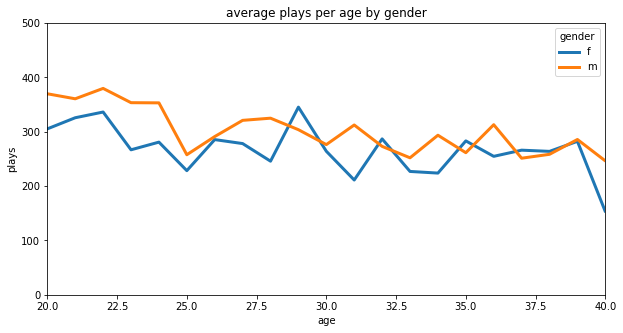

In [20]:
fig, ax = plt.subplots(figsize=(10,5))
userArtist.groupby(['age','gender']).mean()['plays'].unstack().plot(ax=ax, linewidth=3)
plt.xlabel('age')
plt.ylabel('plays')
plt.xlim((20,40)) 
plt.ylim((0, 500))
plt.title('average plays per age by gender')
plt.show()

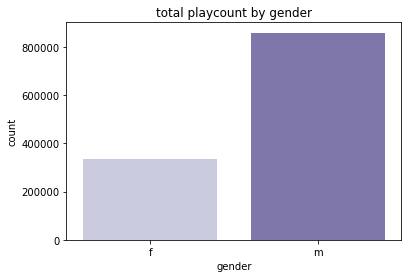

In [21]:
female_plays = female[['gender', 'plays']]
male_plays = male[['gender', 'plays']]

# plot total playcoumt males vs females
joint_avgs = pd.concat([female_plays, male_plays])
sns.countplot(x="gender", data=joint_avgs, palette='Purples')
plt.title('total playcount by gender')
plt.show()

## Data Preprocessing

In [22]:
# user-artist df post filter of popular artists only  
# users: 26306
# artists: 7668
# plays = 7013
userArtist.nunique()

users     26306
artist     7668
gender        2
plays      7013
age          32
dtype: int64

In [23]:
# Convert df to binary pivot table
userArtist['plays'] = userArtist['plays'].astype(int)
music_mat = userArtist.pivot_table(index='artist', columns='users', values='plays').fillna(int(0)).apply(np.sign)
music_sparse = csr_matrix(music_mat.values)

Check cosine distances of users using pairwise_distance function

In [24]:
# calculate cosine distance of users; clear distance relationships between users
user_similarity = pairwise_distances(music_sparse.T, metric='cosine')
# check results of user cosine distance
user_similarity

array([[ 0.        ,  1.        ,  1.        , ...,  0.84607018,
         1.        ,  1.        ],
       [ 1.        ,  0.        ,  1.        , ...,  1.        ,
         0.97724921,  0.93868607],
       [ 1.        ,  1.        ,  0.        , ...,  1.        ,
         0.90971061,  1.        ],
       ..., 
       [ 0.84607018,  1.        ,  1.        , ...,  0.        ,
         0.97777229,  0.98003192],
       [ 1.        ,  0.97724921,  0.90971061, ...,  0.97777229,
         0.        ,  0.94141251],
       [ 1.        ,  0.93868607,  1.        , ...,  0.98003192,
         0.94141251,  0.        ]])

In [25]:
# calculate cosine distance of items
item_similarity = pairwise_distances(music_sparse, metric='cosine')
# check results of item cosine distance
item_similarity

array([[ 0.        ,  1.        ,  1.        , ...,  1.        ,
         0.98069052,  1.        ],
       [ 1.        ,  0.        ,  1.        , ...,  1.        ,
         1.        ,  1.        ],
       [ 1.        ,  1.        ,  0.        , ...,  1.        ,
         1.        ,  1.        ],
       ..., 
       [ 1.        ,  1.        ,  1.        , ...,  0.        ,
         0.8509288 ,  0.9       ],
       [ 0.98069052,  1.        ,  1.        , ...,  0.8509288 ,
         0.        ,  0.9254644 ],
       [ 1.        ,  1.        ,  1.        , ...,  0.9       ,
         0.9254644 ,  0.        ]])

## Predictions

In [26]:
# Create NearestNeigbor instance and fit data for collaberative filtering and 
user_knn = NearestNeighbors(metric='cosine', algorithm='brute').fit(music_sparse)

Item-item cosine similarity check

In [27]:
# query users along row index
query = np.random.choice(music_mat.shape[0])
# find distance and index of artist value versus six closest neighbors
dist, ind = user_knn.kneighbors(music_mat.iloc[query, :].values.reshape(1, -1), n_neighbors = 6)

for i in range(0, len(dist.flatten())):
    if i == 0:
        print 'Similar artists to {} inlude:\n'.format(music_mat.index[query].upper())
    else:
        like_artist = music_mat.index[ind.flatten()[i]]
        like_dist = dist.flatten()[i]
        print '{}: {}'.format('artist', like_artist.upper())
        print '{}: {}'.format('cosine:', round(like_dist, 3))
        print'\n'

Similar artists to CATHEDRAL inlude:

artist: REVEREND BIZARRE
cosine:: 0.739


artist: SAINT VITUS
cosine:: 0.77


artist: CANDLEMASS
cosine:: 0.781


artist: BOLT THROWER
cosine:: 0.811


artist: GRAND MAGUS
cosine:: 0.812




In [28]:
# User-item collaberative filtering of random user 
random_user = np.random.choice(userArtist.users)
random_user_value = music_mat[random_user]
# Pairwise correlation of top five similar users 
user_corr = music_mat.corrwith(random_user_value)[:10]

In [29]:
print 'Users like {} include the following:'.format(random_user), '\n'
print user_corr

Users like 7dd9efbf7ebd6a2ef363d3887ba1db877f4267d6 include the following: 

users
00007a47085b9aab8af55f52ec8846ac479ac4fe   -0.006736
0002dd2154072434d26e5409faa591bfb260a01e    0.263414
00041cbfdd019b5431f926133266cc4ba38219bb   -0.004806
0008b075deee53a3a090668c7ec581e15c3d8430   -0.006590
000d109e4a25299eeef77a14d6b6a81479d1ac0e   -0.007744
000d8c54934cc3a9eab276ccb412dbf52b980a44    0.011575
000f5ca9514226b8b1589f57f02bbdc839bf8727    0.013463
001169ca4be3a1ed81e2f510039f3dcd663313e8   -0.007553
00141206c6d82c1f53fe895b99064318be656ee0   -0.006878
00179de35ed4053bf6b637268e303b0f2b2cb55f   -0.006949
dtype: float64


## Conclusions

This report demonstrated the necessary data wrangling procedures to prepare inputs for EDA, statistical examination and predictions of similar items. By focusing on active users, given a minimal listening threshold, coupled with artists whose popularity serves as a function of their total plays, the EDA illustrated a clear majority of male users across the active 20-40 age range. 

The item to item collaberative filtering using the NearestNeighbors model showed effective given the dimensions of the prediction data. Further research should consider modeling methods more suitable for scalable music recommender engines. This would allow for maintained accuracy given more artists and more users. 